# Project 2: Pneumonia X-rays

#### Dataset was found on Kaggle and contains 5,863 images with two categories of Pneumonia and Normal

#### The images were selected from Guangzhou Women and Children's Medical center and is of pediatric patients ranging from 1 year to 5 years old

#### Low quality and unreadable scans were taken out of the dataset

In [ ]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve


In [2]:

dataset_path = r"C:\Users\Charl\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2"
print("Dataset contents:", os.listdir(dataset_path))


Dataset contents: ['chest_xray']


* This gets the subdirectories train, test, and val and will make a new output folder of resized images with padding while preserving the images.

In [3]:

def image_resize(size):
    path_1 = r"C:\Users\Charl\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2"
    output_path = r"C:\Users\Charl\Desktop\chest_xray_resized"
    
    input_dirs = [os.path.join(dataset_path, "chest_xray", "train"),
                  os.path.join(dataset_path, "chest_xray", "val"),
                  os.path.join(dataset_path, "chest_xray", "test")]
    
    output_dirs = [os.path.join(output_path, f"resized_{size}", "train"),
                   os.path.join(output_path, f"resized_{size}", "val"),
                   os.path.join(output_path, f"resized_{size}", "test")]

    target_size = (size, size)
    
    for output_dir in output_dirs:
        os.makedirs(output_dir, exist_ok=True)

    def resize_with_padding(image, target_size):
        img_ratio = image.width / image.height
        target_ratio = target_size[0] / target_size[1]

        if img_ratio > target_ratio:
            new_width = target_size[0]
            new_height = round(new_width / img_ratio)
        else:
            new_height = target_size[1]
            new_width = round(new_height * img_ratio)

            
        img_resized = image.resize((new_width, new_height), Image.LANCZOS)

        new_image = Image.new("RGB", target_size, (0, 0, 0))
        new_image.paste(img_resized, ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2))

        return new_image

    for i in range(3): 
        for root, _, files in os.walk(input_dirs[i]):
            for file in files:
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path)
                    img_resized = resize_with_padding(img, target_size)
                    
                    relative_path = os.path.relpath(root, input_dirs[i])
                    output_dir = os.path.join(output_dirs[i], relative_path)
                    os.makedirs(output_dir, exist_ok=True)
                    output_path = os.path.join(output_dir, file)
                    img_resized.save(output_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

image_resize(224)
image_resize(256)
 

* I loaded the images to normalize them and then processed them as numpy arrays to help prepare for next steps

In [4]:

def images_to_arrays(input_dir, target_size=(224, 224)):
    if not os.path.exists(input_dir):
        raise ValueError(f"The input directory does not exist: {input_dir}")

    image_arrays = []
    labels = []
    classes = sorted(os.listdir(input_dir))  
    
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  
            
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)

            try:
                if not os.path.isfile(file_path):
                    print(f"Skipping non-file: {file_path}")
                    continue

                img = Image.open(file_path).convert("RGB")
                img_resized = img.resize(target_size, Image.LANCZOS)
                img_array = np.array(img_resized) / 255.0 

                image_arrays.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    if not image_arrays:
        raise ValueError(f"No valid images found in directory: {input_dir}")

    return np.array(image_arrays), np.array(labels)


In [5]:
train_dir = r"C:\Users\Charl\Desktop\chest_xray_resized\resized_224\train"
val_dir = r"C:\Users\Charl\Desktop\chest_xray_resized\resized_224\val"
test_dir = r"C:\Users\Charl\Desktop\chest_xray_resized\resized_224\test"

X_train_image, y_train_image = images_to_arrays(train_dir)
X_val_image, y_val_image = images_to_arrays(val_dir)
X_test_image, y_test_image = images_to_arrays(test_dir)

In [6]:
print(f"Training data shape: {X_train_image.shape}")
print(f"Validation data shape: {X_val_image.shape}")
print(f"Test data shape: {X_test_image.shape}")

Training data shape: (5216, 224, 224, 3)
Validation data shape: (16, 224, 224, 3)
Test data shape: (624, 224, 224, 3)


* loads the images to use for training 

In [7]:

train_dir = r"C:\Users\Charl\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\train"

datagen = ImageDataGenerator(rescale=1.0 / 255) 

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode='binary')

Found 5216 images belonging to 2 classes.


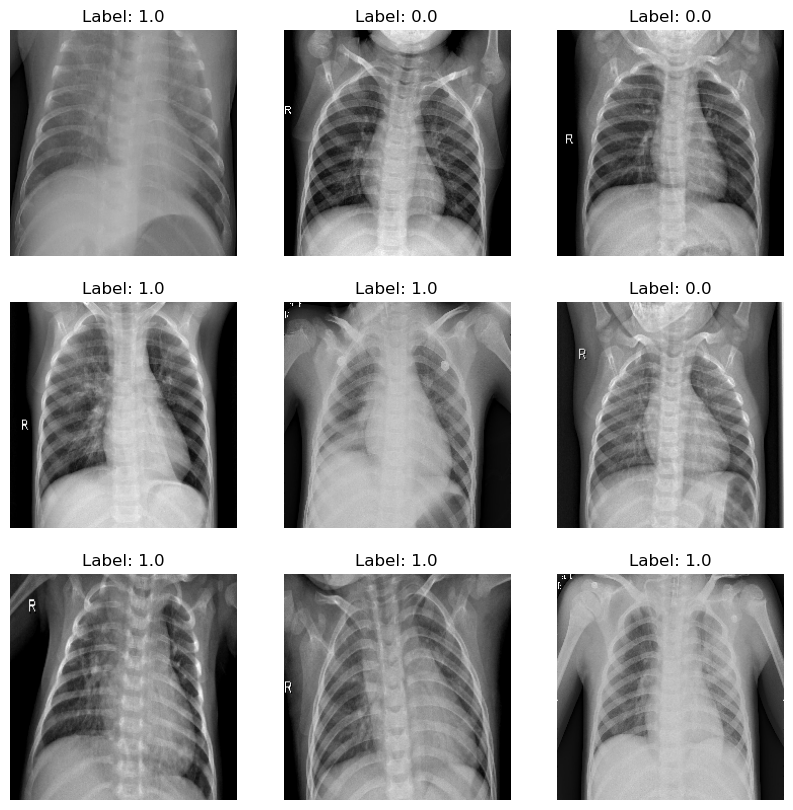

In [10]:

images, labels = next(train_data)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.show()

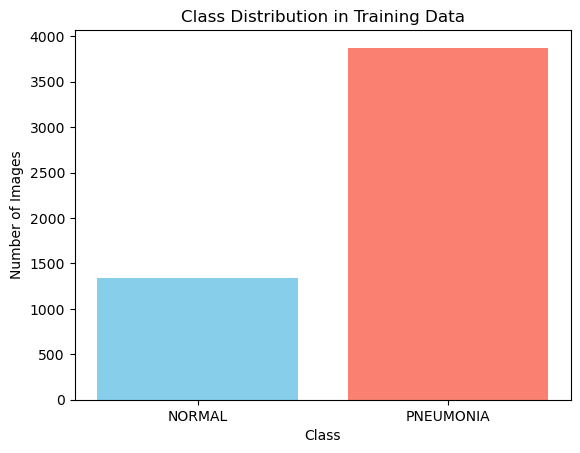

In [11]:


class_labels = list(train_data.class_indices.keys())
class_counts = [train_data.labels.tolist().count(i) for i in np.unique(train_data.labels)]

plt.bar(class_labels, class_counts, color=['skyblue', 'salmon'])
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

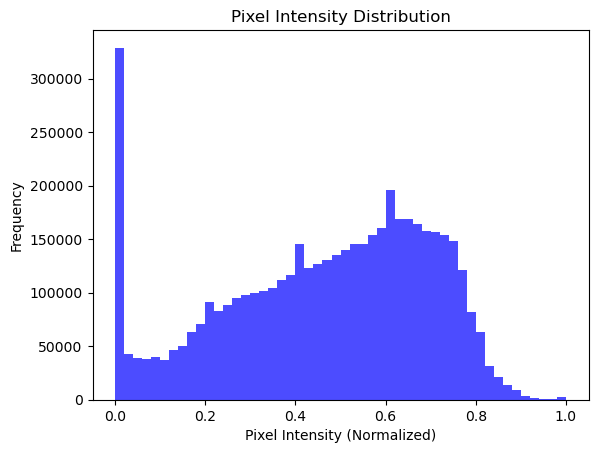

In [13]:
images, _ = next(train_data) 
flattened_images = images.reshape(-1)
plt.hist(flattened_images, bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (Normalized)")
plt.ylabel("Frequency")
plt.show()

Found 5216 images belonging to 2 classes.


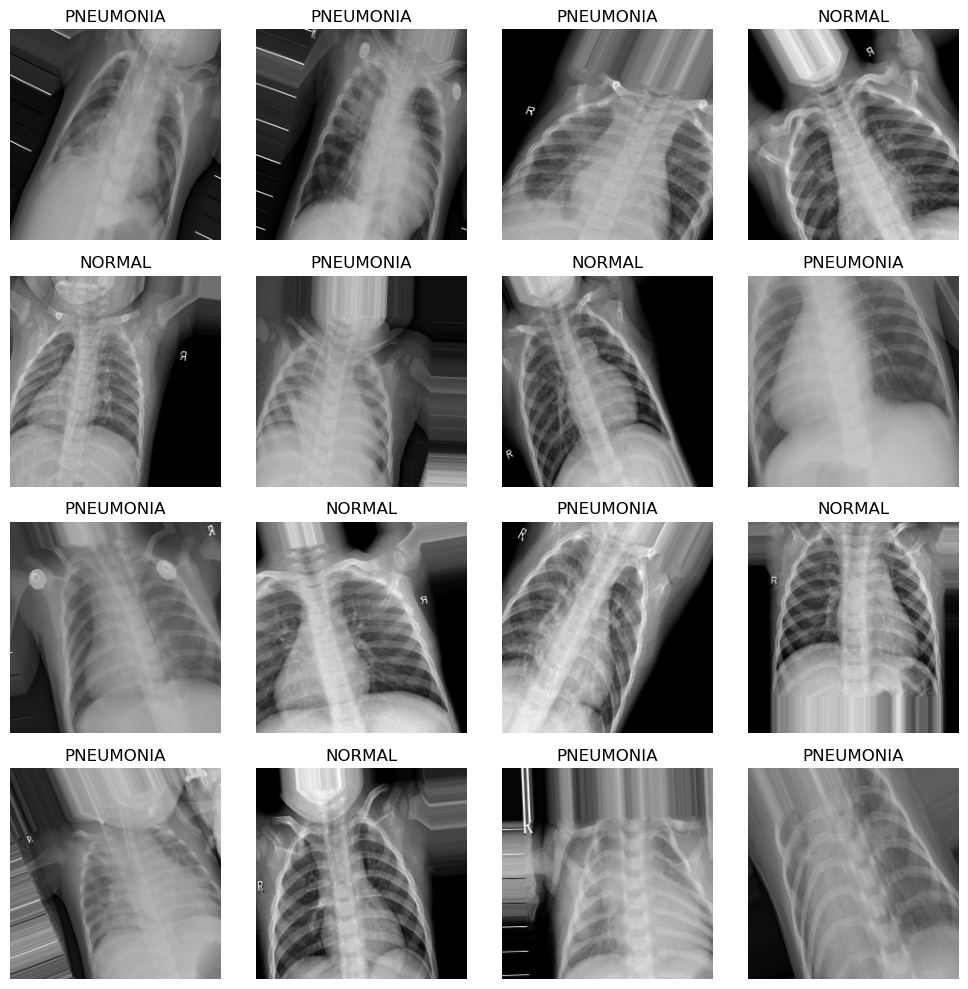

In [20]:
def visualize_images(data_generator, class_labels, num_images=16):
    images, labels = next(data_generator)

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i]) 
        plt.title(class_labels[int(labels[i])])  
        plt.axis("off")
    plt.tight_layout()
    plt.show()

augmented_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

augmented_data = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

visualize_images(augmented_data, class_labels)

# Non Supervised Learning

* Using pre-trained VGG16 to get useful features that will help train learning models

In [12]:

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.output)

features_list = []
labels_list = []

for batch, labels in train_data:
    features = feature_extractor.predict(batch)
    features_list.append(features)
    labels_list.append(labels)
    
    if len(features_list) * train_data.batch_size >= train_data.samples:
        break

X_train_features = np.concatenate(features_list).reshape(train_data.samples, -1)
y_train_labels = np.concatenate(labels_list)

print(f"Extracted features shape: {X_train_features.shape}")
print(f"Labels shape: {y_train_labels.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

In [21]:
X_train_flattened = X_train_image.reshape(X_train_image.shape[0], -1)
print(f"Flattened images shape: {X_train_flattened.shape}")

Flattened images shape: (5216, 150528)


In [22]:

pca = PCA(n_components=50)
X_reduced_pca = pca.fit_transform(X_train_flattened)

print(f"Reduced features shape (PCA): {X_reduced_pca.shape}")

Reduced features shape (PCA): (5216, 50)


In [28]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_reduced_pca, y_train_image)

y_pred = rf_model.predict(X_reduced_pca)
print(classification_report(y_train_image, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1341
           1       1.00      1.00      1.00      3875

    accuracy                           1.00      5216
   macro avg       1.00      1.00      1.00      5216
weighted avg       1.00      1.00      1.00      5216



In [24]:

X_train, X_val, y_train, y_val = train_test_split(X_train_flattened, y_train_labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.28      0.02      0.03       294
         1.0       0.72      0.98      0.83       750

    accuracy                           0.71      1044
   macro avg       0.50      0.50      0.43      1044
weighted avg       0.59      0.71      0.61      1044



In [23]:
X_train_features = feature_extractor.predict(X_train_image).reshape(X_train_image.shape[0], -1)
print(f"CNN features shape: {X_train_features.shape}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 1126s 7s/step
CNN features shape: (5216, 25088)


##### K-means

In [26]:

def extract_features(data):
    return feature_extractor.predict(data)

X_train_features = extract_features(X_train_image)
X_val_features = extract_features(X_val_image)
X_test_features = extract_features(X_test_image)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1132s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step


In [27]:

def images_to_array_no_labels(input_dir, target_size=(224, 224)):
    image_arrays = []
    for root, _, files in os.walk(input_dir):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            try:
                img = Image.open(file_path).convert("RGB") 
                img_resized = img.resize(target_size, Image.LANCZOS)
                img_array = np.array(img_resized) / 255.0 
                image_arrays.append(img_array)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return np.array(image_arrays)

input_dir = r"C:\Users\Charl\Desktop\chest_xray_resized\resized_224"  
images = images_to_array_no_labels(input_dir, target_size=(224, 224))
print(f"Loaded {images.shape[0]} images of shape {images.shape[1:]}")


Loaded 5856 images of shape (224, 224, 3)


In [28]:
print(f"Shape of images: {images.shape}")

if len(images.shape) == 3: 
    images = np.expand_dims(images, axis=-1)
    print(f"Adjusted shape for grayscale images: {images.shape}")

# Flatten images
if len(images.shape) == 4: 
    num_samples, height, width, channels = images.shape
    images_flattened = images.reshape(num_samples, height * width * channels)
    print(f"Flattened image shape: {images_flattened.shape}")
else:
    raise ValueError(f"Unexpected image shape: {images.shape}")

Shape of images: (5856, 224, 224, 3)
Flattened image shape: (5856, 150528)


In [29]:
X_train_flattened = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flattened = X_val_features.reshape(X_val_features.shape[0], -1)
X_test_flattened = X_test_features.reshape(X_test_features.shape[0], -1)

num_samples, height, width, channels = images.shape
images_flattened = images.reshape(num_samples, height * width * channels)

# Dimensionality Reduction

In [32]:

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.output)

X_train_features = feature_extractor.predict(X_train_image).reshape(X_train_image.shape[0], -1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1193s 7s/step


* I plotted the PCA with the two classes and it shows an overlap between the Normal and Pneumonia classes

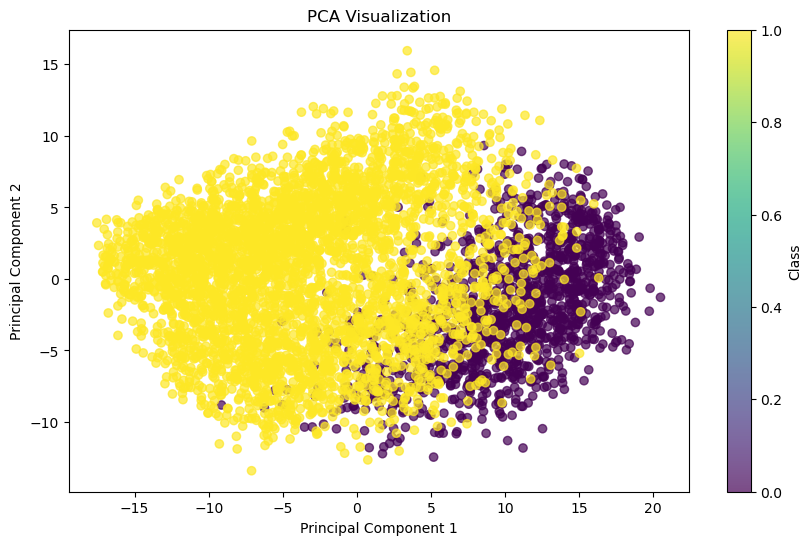

In [33]:

pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X_train_features)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y_train_image, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# CNN Model

In [36]:

tf.random.set_seed(907)
np.random.seed(907)
random.seed(907)

In [37]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Charl\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* When fitting the model it shows that the CNN model is learning the training data well as the accuracy increases but that there is a show of overfitting

In [38]:
history = model.fit(
    X_train_image, y_train_image,  
    validation_data=(X_val_image, y_val_image),
    epochs=10,  
    batch_size=32, 
    verbose=1 
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.8091 - loss: 0.4718 - val_accuracy: 0.8125 - val_loss: 0.3094
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9357 - loss: 0.1722 - val_accuracy: 0.8125 - val_loss: 0.2737
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9582 - loss: 0.1289 - val_accuracy: 0.8750 - val_loss: 0.3157
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9640 - loss: 0.0996 - val_accuracy: 0.8125 - val_loss: 0.3693
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9700 - loss: 0.0807 - val_accuracy: 0.8750 - val_loss: 0.3454
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9751 - loss: 0.0695 - val_accuracy: 0.8750 - val_loss: 0.3927
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9724 - loss: 0.0608 - val_accuracy: 0.8750 - val_loss: 0.4078
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9839 - loss: 0.0514 - val_accu

In [39]:

y_pred = np.argmax(model.predict(X_test_image), axis=1)

print(classification_report(y_test_image, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

conf_matrix = confusion_matrix(y_test_image, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.46      0.63       234
   PNEUMONIA       0.75      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624

Confusion Matrix:
[[108 126]
 [  3 387]]


In [40]:
test_loss, test_accuracy = model.evaluate(X_test_image, y_test_image)
print(test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.6331 - loss: 2.2266
0.7932692170143127


* Plotted the accuracy and the loss, the first one shows training accuracy is high and validation is low
* The second shows overfitting on the validation 

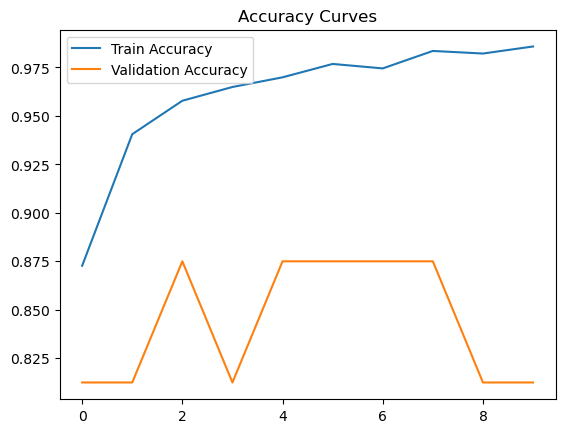

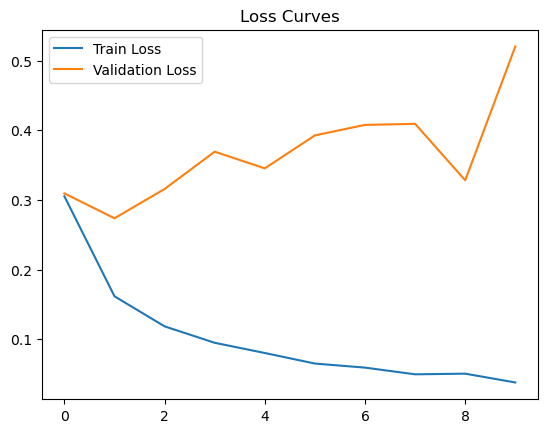

In [41]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [42]:
predictions = model.predict(X_test_image)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step


In [44]:
index=2
def plot_image(index, predictions_array, true_label, image):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary) 

    predicted_label = tf.argmax(predictions_array).numpy() 
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"Predicted: {'PNEUMONIA' if predicted_label == 1 else 'NORMAL'}, "
        f"True: {'PNEUMONIA' if true_label == 1 else 'NORMAL'}",
        color=color)
    
def plot_value_array(index, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2), ['NORMAL', 'PNEUMONIA']) 
    plt.yticks([])
    bars = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = tf.argmax(predictions_array).numpy()

    bars[predicted_label].set_color('red')  
    bars[true_label].set_color('blue')

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step


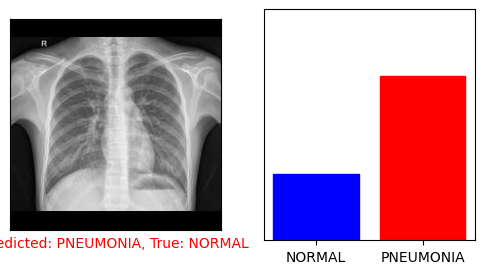

In [45]:

predictions = model.predict(X_test_image)

index = 12
img = X_test_image[index]  
true_label = y_test_image[index]  
predictions_array = predictions[index]  

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(index, predictions_array, true_label, img)
plt.subplot(1, 2, 2)
plot_value_array(index, predictions_array, true_label)
plt.show()


* shows the model can distinguish between the two classes but has room for improvment still

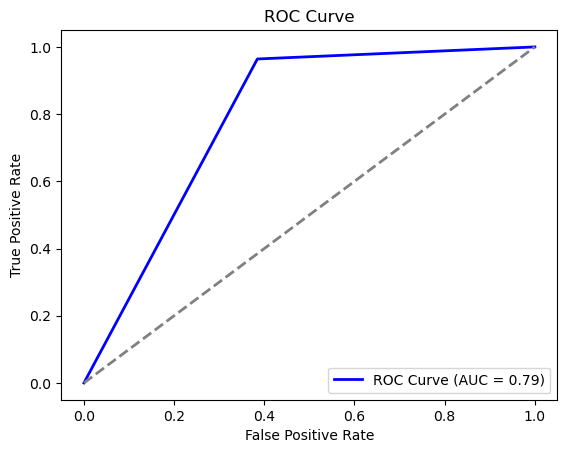

In [55]:

fpr, tpr, thresholds = roc_curve(y_test_image, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') 
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Random Forest

In [47]:

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg_base.input, outputs=vgg_base.output)

X_train_features = feature_extractor.predict(X_train_image).reshape(X_train_image.shape[0], -1)
X_val_features = feature_extractor.predict(X_val_image).reshape(X_val_image.shape[0], -1)
X_test_features = feature_extractor.predict(X_test_image).reshape(X_test_image.shape[0], -1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_features, y_train_image)

y_pred_rf = rf_model.predict(X_test_features)
rf_accuracy = accuracy_score(y_test_image, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy:.2f}")

print(classification_report(y_test_image, y_pred_rf, target_names=['NORMAL', 'PNEUMONIA']))


163/163 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step
Random Forest Test Accuracy: 0.80
              precision    recall  f1-score   support

      NORMAL       0.97      0.47      0.63       234
   PNEUMONIA       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.73      0.75       624
weighted avg       0.84      0.80      0.77       624



* The confusion matrix shows that it is very good at finding Pneumonia but it finds the Normal cases hard to diagnose with the 124

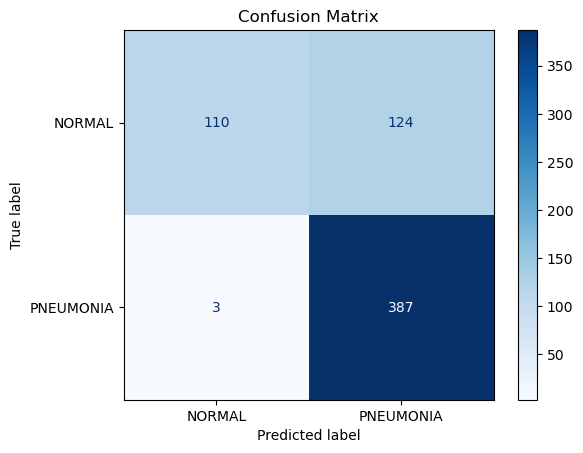

In [60]:

cm = confusion_matrix(y_test_image, y_pred_rf, labels=[0, 1]) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

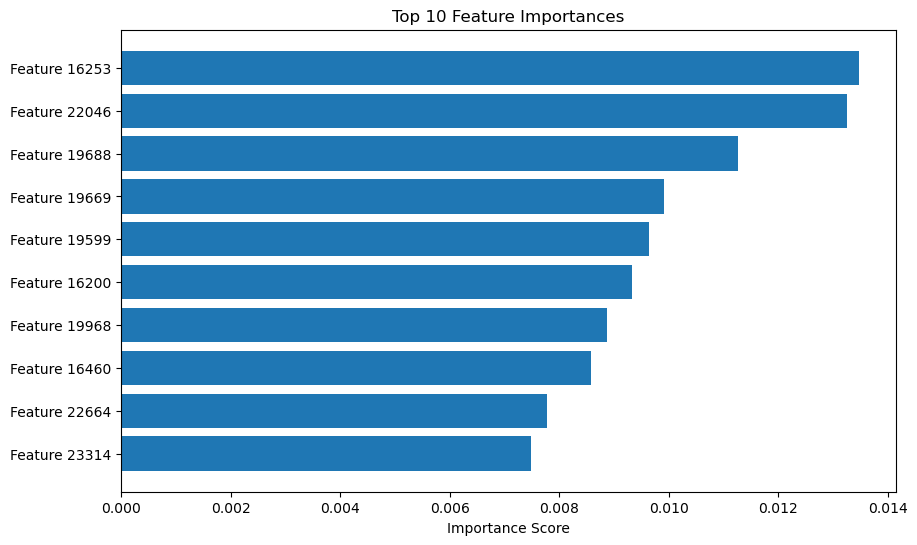

In [49]:

feature_importances = rf_model.feature_importances_
top_features = np.argsort(feature_importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), feature_importances[top_features], align='center')
plt.yticks(range(len(top_features)), [f"Feature {i}" for i in top_features])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances')
plt.show()

* Since the dataset is unbalanced I decided to undersample the data to make it equal

In [50]:

unique, counts = np.unique(y_train_image, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Distribution:", class_counts)

minority_class = 0 if class_counts[0] < class_counts[1] else 1
majority_class = 1 if minority_class == 0 else 0

minority_indices = np.where(y_train_image == minority_class)[0]
majority_indices = np.where(y_train_image == majority_class)[0]

print(f"Minority class ({minority_class}) size:", len(minority_indices))
print(f"Majority class ({majority_class}) size:", len(majority_indices))

random.seed(42)  
undersampled_majority_indices = random.sample(list(majority_indices), len(minority_indices))

balanced_indices = np.concatenate([undersampled_majority_indices, minority_indices])

np.random.shuffle(balanced_indices)

X_train_balanced = X_train_features[balanced_indices]
y_train_balanced = y_train_image[balanced_indices]

print("Balanced class distribution:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))


Class Distribution: {0: 1341, 1: 3875}
Minority class (0) size: 1341
Majority class (1) size: 3875
Balanced class distribution: {0: 1341, 1: 1341}


In [51]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred = rf_model.predict(X_test_features)
print("Classification Report:")
print(classification_report(y_test_image, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_image, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.73       234
           1       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.82       624

Confusion Matrix:
[[144  90]
 [ 14 376]]


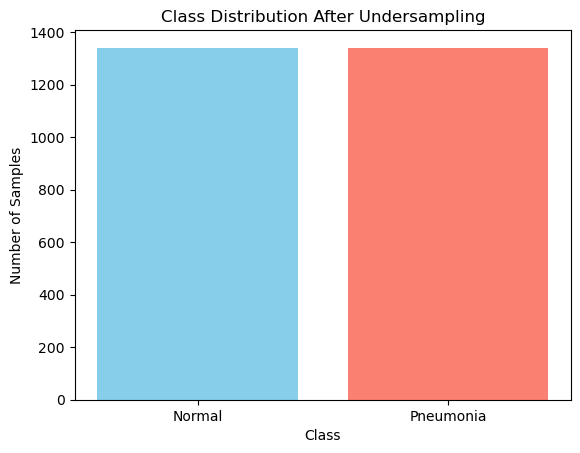

In [62]:

unique, counts = np.unique(y_train_balanced, return_counts=True)
class_counts = dict(zip(unique, counts))

plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Undersampling')
plt.show()

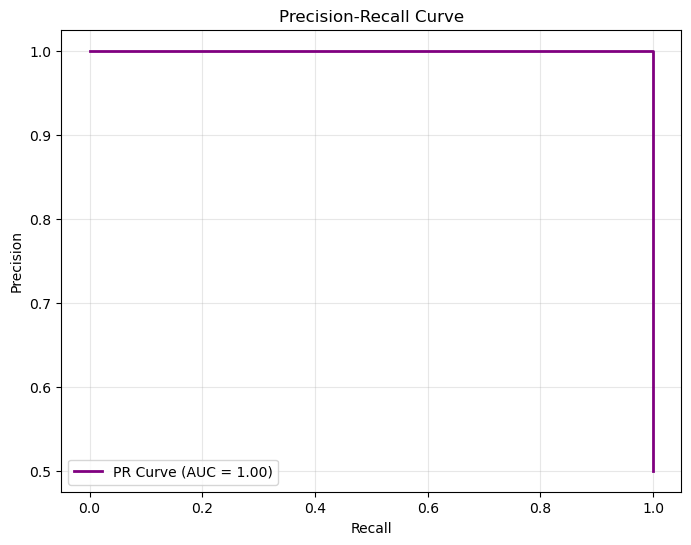

In [65]:

y_pred_probs_balanced = rf_model.predict_proba(X_val_features)[:, 1] 

precision, recall, thresholds = precision_recall_curve(y_val_image, y_pred_probs_balanced)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

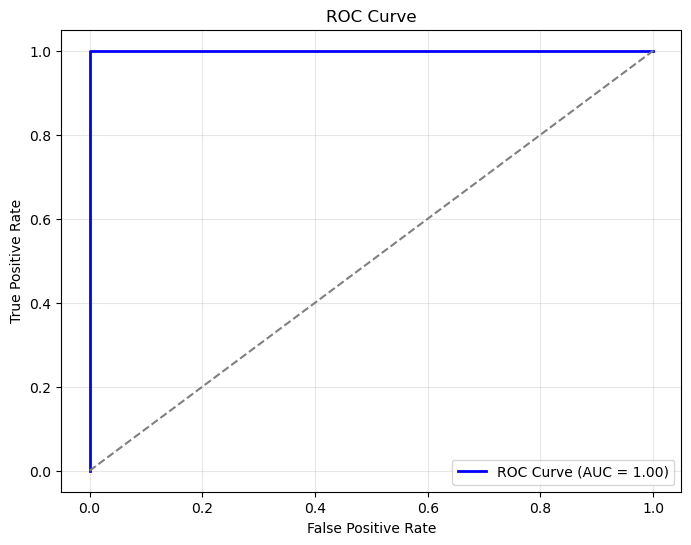

In [66]:

fpr, tpr, thresholds = roc_curve(y_val_image, y_pred_probs_balanced)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

* Plotted the learning curve which shows that the accuracy is 100% and that the validation is increasing as it learns. But there is still a case of overfitting.

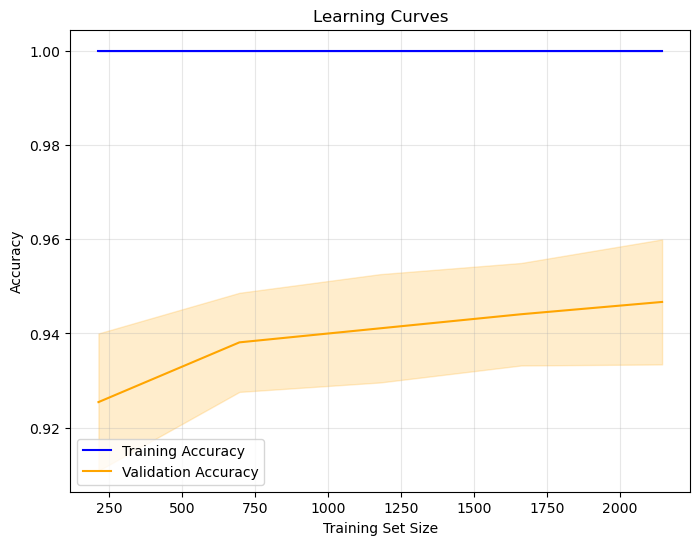

In [67]:

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

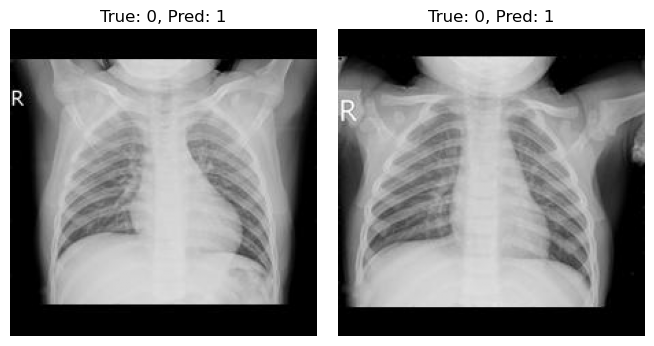

In [68]:

misclassified_indices = np.where(y_val_image != y_pred_balanced)[0]
random_misclassified = random.sample(list(misclassified_indices), min(len(misclassified_indices), 9))  # Sample 9 images

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_misclassified):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val_image[idx].reshape(224, 224, 3)) 
    plt.title(f"True: {y_val_image[idx]}, Pred: {y_pred_balanced[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Conclusions

* Overall this dataset had two classes, Normal and Pneumonia, and the normal class was underrepresented
* It was difficult for the images to be classified in some cases because of the similarities in them 
* There was good representation in the training set but the validation set had a bad accuracy
* Some normal cases were classified as pneumonia but in the medical field that would be preferred
* So at the end, I think that the data needs to be sampled more because of the class imbalance and more model tuning could be used